<a href="https://colab.research.google.com/github/heysourin/Customer-feedback-analysis/blob/main/Customer_feedback_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
#!pip install -r requiremnts.txt

In [74]:
!kaggle datasets download -d sid321axn/amazon-alexa-reviews

Dataset URL: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews
License(s): other
amazon-alexa-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [75]:
from zipfile import ZipFile
dataset = 'amazon-alexa-reviews.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Data, extracted!")

Data, extracted!


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
df = pd.read_csv('amazon_alexa.tsv', sep='\t')

In [78]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [79]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [80]:
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [81]:
df.dropna(inplace=True)

In [82]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [83]:
df['length'] = df['verified_reviews'].str.len()


In [84]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [85]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

<Axes: xlabel='rating', ylabel='Count'>

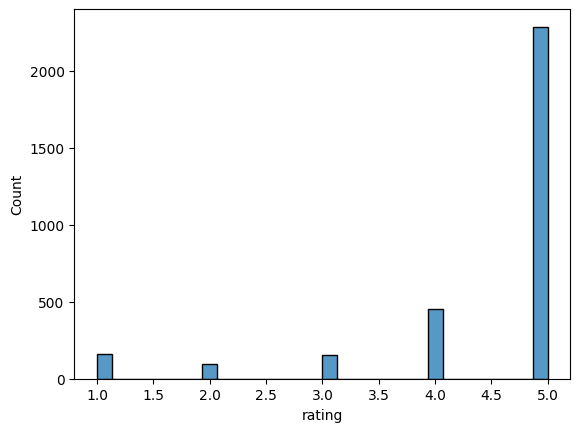

In [86]:

sns.histplot(df['rating'])

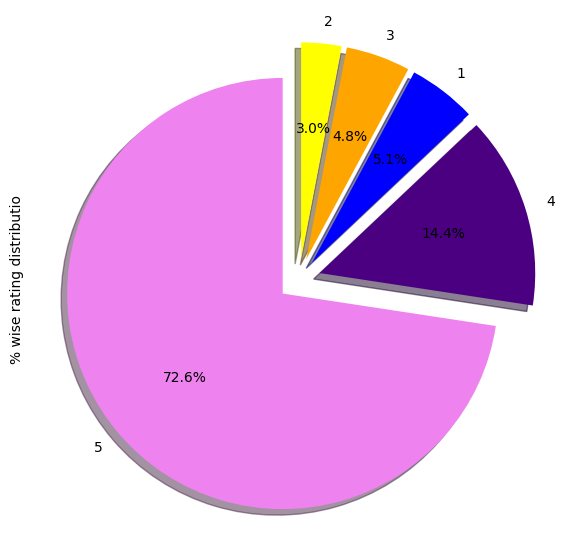

In [87]:
fig = plt.figure(figsize=(7,7))
colors = ('violet', 'indigo','blue','orange','yellow')
tags = df['rating'].value_counts()/df.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, explode=explode, label='% wise rating distributio')
from io import  BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")

In [88]:
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pwal9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re
from sklearn.tree import DecisionTreeClassifier
import pickle

In [90]:
#COUNT VECTORIZER

cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

---
## **Models:**

In [91]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, len(df)):
  review = re.sub('[^a-zA-Z]', '', df.iloc[i]['verified_reviews'])
  review = review.lower()
  review = review.split()
  review = [stemmer.stem(word) for word in review if not word in set(STOPWORDS)]
  review = ' '.join(review)
  corpus.append(review)

In [92]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [93]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [94]:
X.shape, y.shape

((3149, 2233), (3149,))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2204, 2233), (945, 2233), (2204,), (945,))

In [96]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [97]:
import pickle
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [98]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scl, y_train)

RandomForestClassifier()

In [99]:
print("Training Accuracy :", rfc.score(X_train_scl, y_train))
print("Testing Accuracy :", rfc.score(X_test_scl, y_test))

Training Accuracy : 0.9936479128856625
Testing Accuracy : 0.9195767195767196


In [100]:
y_preds = rfc.predict(X_test_scl)

In [101]:
cm = confusion_matrix(y_test, y_preds)

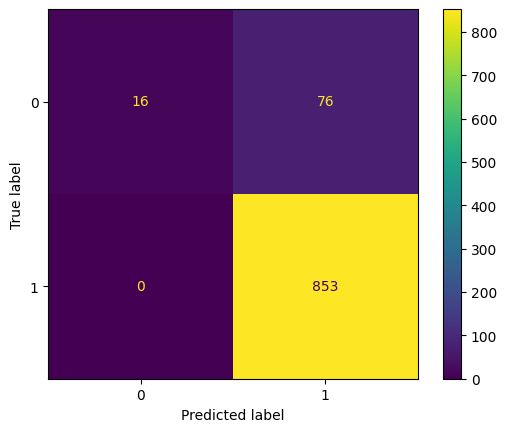

In [102]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
cm_display.plot()
plt.show()

In [103]:
# k-fold cross validation
accuracies = cross_val_score(estimator = rfc, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9337659399424105
Standard Variance : 0.00699965233408734


In [104]:
params = {
  'bootstrap': [True],
  'max_depth': [80, 100],
  'min_samples_split': [8, 12],
  'n_estimators': [100, 300]
}

In [105]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = rfc, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [106]:
# Getting the best parameters:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'min_samples_split': 12,
 'n_estimators': 300}

In [107]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.38725045372051
Cross validation mean accuracy on test set : 92.83688747731398
Accuracy score for test set : 0.9195767195767196


In [108]:
rfc_new= RandomForestClassifier(
  bootstrap=True,
  max_depth=100,
  min_samples_split=12,
  n_estimators=300,
  random_state=42  # Set a random state for reproducibility
)

In [109]:
rfc_new.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=12, n_estimators=300,
                       random_state=42)

In [110]:
y_pred = rfc_new.predict(X_test)

In [111]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 90.58%


In [112]:
#Saving the Random forest classifier
pickle.dump(rfc, open('Models/model_rfc.pkl', 'wb'))

---
## **XGBoost:**

In [113]:
# XGBoostClassifer
xgbc = XGBClassifier()
xgbc.fit(X_train_scl, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", xgbc.score(X_train_scl, y_train))
print("Testing Accuracy :", xgbc.score(X_test_scl, y_test))

Training Accuracy : 0.925589836660617
Testing Accuracy : 0.9026455026455027


In [115]:
y_preds = xgbc.predict(X_test)

In [116]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  0  92]
 [  0 853]]


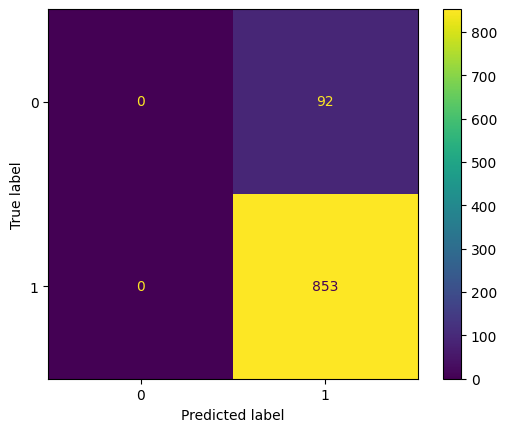

In [117]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgbc.classes_)
cm_display.plot()
plt.show()

In [118]:
#Saving the XGBoost classifier
pickle.dump(xgbc, open('Models/model_xgb.pkl', 'wb'))

In [119]:
#Decision tree classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [120]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", dtc.score(X_train_scl, y_train))
print("Testing Accuracy :", dtc.score(X_test_scl, y_test))

Training Accuracy : 0.9936479128856625
Testing Accuracy : 0.9195767195767196


In [121]:
y_preds = dtc.predict(X_test)

In [122]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 16  76]
 [  0 853]]


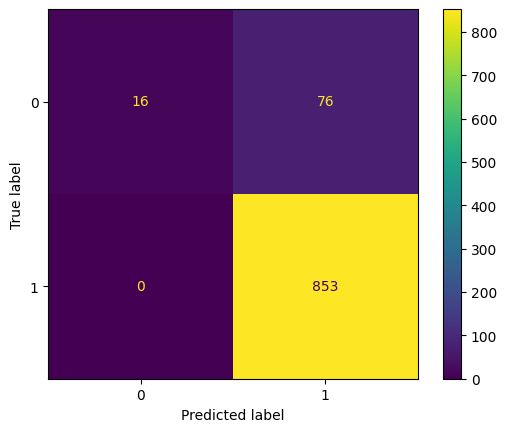

In [123]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtc.classes_)
cm_display.plot()
plt.show()

In [124]:
#Saving the decision tree classifier
pickle.dump(dtc, open('Models/model_dtc.pkl', 'wb'))